In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from PIL import Image

import cv2

from sklearn.experimental import enable_halving_search_cv

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


from xgboost import XGBClassifier

from sklearn.model_selection import (train_test_split,cross_val_predict,cross_val_score
                                     ,RandomizedSearchCV,GridSearchCV,HalvingGridSearchCV,HalvingRandomSearchCV)
from sklearn.preprocessing import StandardScaler,OrdinalEncoder

from sklearn.metrics import (f1_score,precision_recall_curve,precision_score
                             ,recall_score,ConfusionMatrixDisplay,accuracy_score)

from plyer import notification
import json
import os 
from discord import SyncWebhook


In [8]:
def alert():
    notification.notify(
    title = "Python",
    message = "Execution Completed",
    timeout = 10
    )
    

In [9]:
test_dir = "dataset/test/"
train_dir = "dataset/train/"

classes = os.listdir(train_dir)
classes

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

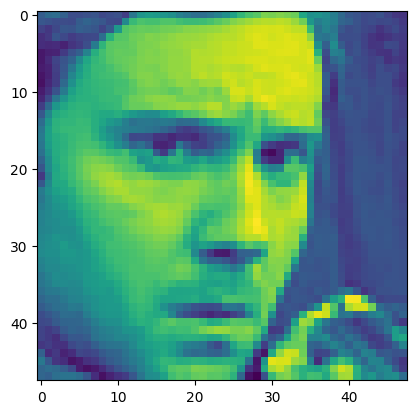

In [10]:
data = np.asarray(Image.open(r"dataset\train\angry\im0.png"))
# plt.imshow(data)
data = data.reshape(48*48)
plt.imshow(data.reshape(48,48))

In [11]:
x_train = []
y_train = []

In [12]:
encoded_classes = [i for i in range(len(classes))]

for i in range(len(classes)):
    datalist = os.listdir(train_dir+classes[i])
    for j in datalist[:1000]:
        data = np.asarray(Image.open(train_dir+classes[i]+"/"+j))
        data_norm = cv2.normalize(data.flatten(),None,0,1,cv2.NORM_MINMAX,dtype=cv2.CV_32F)
        x_train.append(data_norm.flatten())
        y_train.append(encoded_classes[i])
        

x_train = np.array(x_train)
y_train = np.array(y_train)

print(x_train.shape)


(6436, 2304)


In [13]:
def image_show(img):
    data = img.reshape(48,48)
    plt.imshow(cv2.cvtColor(data,cv2.COLOR_BGR2RGB))
    plt.show()

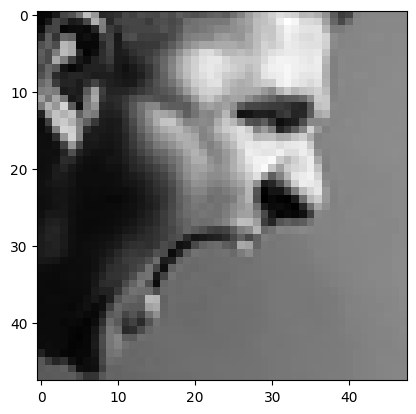

1324


In [14]:
image_show(x_train[10])
print(x_train[0].argmax())

In [15]:
x_train.shape

(6436, 2304)

4


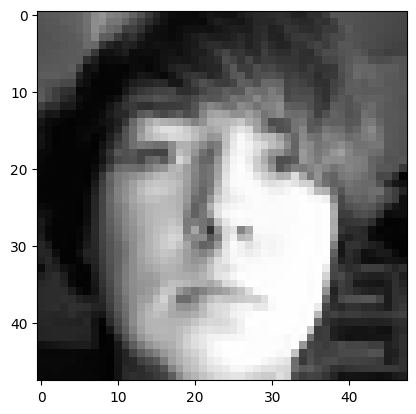

In [16]:
print(y_train[4000])
image_show(x_train[4000])

In [17]:
x_train,x_test,y_train,y_test = train_test_split(x_train,y_train,test_size=0.1,random_state=30)

In [18]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(5792, 2304)
(5792,)
(644, 2304)
(644,)


In [19]:
std_scaler = StandardScaler()
x_train_scaled = std_scaler.fit_transform(x_train)

In [20]:
x_train_scaled[0]


array([ 0.78823686,  0.8466948 ,  1.1754549 , ..., -0.20822097,
       -0.23922019, -0.33580893], dtype=float32)

In [21]:
# ord_encdr = OrdinalEncoder()
# y_train_encoded = ord_encdr.fit_transform(y_train.reshape(-1,1))

In [22]:
# ord_encdr.categories_

In [23]:
rnd_model = XGBClassifier(verbose=1)



In [28]:
hyperF = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000],
           'seed' : [20]}



gridF = HalvingRandomSearchCV(rnd_model, hyperF,factor=2,random_state=42, cv = 3, verbose = 3, 
                      n_jobs = -1)
bestF = gridF.fit(x_train_scaled, y_train)

n_iterations: 8
n_required_iterations: 8
n_possible_iterations: 8
min_resources_: 42
max_resources_: 5792
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 137
n_resources: 42
Fitting 3 folds for each of 137 candidates, totalling 411 fits
----------
iter: 1
n_candidates: 69
n_resources: 84
Fitting 3 folds for each of 69 candidates, totalling 207 fits
----------
iter: 2
n_candidates: 35
n_resources: 168
Fitting 3 folds for each of 35 candidates, totalling 105 fits
----------
iter: 3
n_candidates: 18
n_resources: 336
Fitting 3 folds for each of 18 candidates, totalling 54 fits
----------
iter: 4
n_candidates: 9
n_resources: 672
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 5
n_candidates: 5
n_resources: 1344
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 6
n_candidates: 3
n_resources: 2688
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 7
n_candidates: 2
n_resources: 5376
Fitti

In [ ]:
with open("parameter.json","w") as f:
    json.dump(gridF.best_params_,f)
    


webhook = SyncWebhook.from_url("https://discord.com/api/webhooks/1063122746835472466/QWFwQkRFXRtRLa0j21nvMl2D7qQooBs3OiAun2SEwlwSFf0UegILx4SXKxKQ_Gq7FjEr")
webhook.send(f"```{gridF.best_params_}```")
    
# os.system("shutdown /s /t 1")

In [ ]:
# rnd_model.fit(x_train,y_train)

In [ ]:
pred = cross_val_score(rnd_model,x_train_scaled,y_train,cv=3)
print(pred)


In [ ]:
# webhook = SyncWebhook.from_url("https://discord.com/api/webhooks/1063122746835472466/QWFwQkRFXRtRLa0j21nvMl2D7qQooBs3OiAun2SEwlwSFf0UegILx4SXKxKQ_Gq7FjEr")
# webhook.send(f"Execution Complete {pred}")

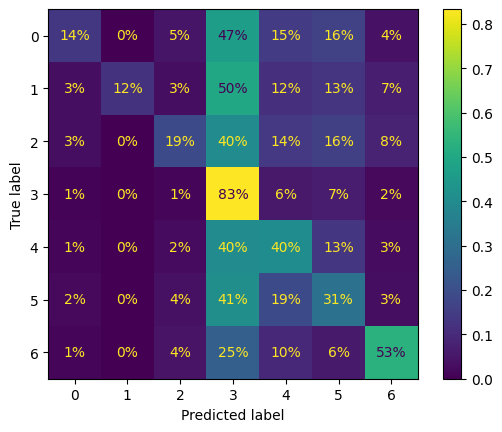

       0          1        2      3        4    5          6
0  angry  disgusted  fearful  happy  neutral  sad  surprised


In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train,pred,values_format='.0%',normalize='true')
plt.show()
print(pd.DataFrame([classes]))